In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imread
import os
import sys
import pickle
import glob
from sklearn.utils import shuffle
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import cv2
from keras import backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, Flatten, Lambda, ELU
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from keras.models import model_from_json
import json
import csv
from math import ceil
from random import sample

Using TensorFlow backend.


### Helper Functions

In [2]:
def reject_outliers(img, data, m=2):
    return img[abs(data - np.mean(data)) < m * np.std(data)], data[abs(data - np.mean(data)) < m * np.std(data)]

def truncate(value, a, b):
    r'''Return `value` if within range `(a, b)` (inclusive),
        otherwise return the closest range limit value.
    '''
    return min(max(value, a), b)


def encoder_y(angle, breadth, offset=0):
    r'''Return the angle as a continuous value, possibly modified by an offset.
    '''
    step = 1.0 / (breadth // 2)
    return angle + step * offset


def onehot_y(angle, breadth, offset=0):
    r'''Return the angle as a one-hot vector of length `breadth`.
        The position of the non-zero value may be displaced by `offset` positions.
        Negative values cause it to shift left, and positive ones, right.
    '''
    encoded = np.zeros(breadth)
    half_breadth = breadth // 2
    i = half_breadth # if angle == 0
    if angle < -1:
        i = 0
    elif angle > 1:
        i = breadth - 1
    elif angle < 0:
        i = int(ceil((half_breadth - 1) * (1.0 + angle)))
    elif angle > 0:
        i = half_breadth + int(ceil(half_breadth * angle))

    i = truncate(i + offset, 0, breadth - 1)

    encoded[i] = 1

    return encoded

## Load Dataset

In [3]:
CENTER_IMAGE = 0
LEFT_IMAGE = 1
RIGHT_IMAGE = 2
STEERING_ANGLE = 3
THROTLE = 4
BREAK = 5
SPEED = 6


MIDDLE_SMOOTH_FORWARD = 0
MIDDLE_TURN_LEFT = 1
MIDDLE_SMOOTH_TURN_LEFT = 2
MIDDLE_SHARP_TURN_LEFT = 3
MIDDLE_TURN_RIGHT = 4
LEFT = 5
RIGHT = 6
VEER_LEFT = 7
VEER_RIGHT = 8


def load(path):
    dataset = []
    with open(path) as file:
        for row in csv.reader(file):
            if float(row[SPEED]) < 1.0:
                continue
                
            if path == veer + veer_left_csv:
                shift = 0.2
            elif path == veer + veer_right_csv:
                shift = -0.2
            else:
                shift = 0

            row = [
                row[CENTER_IMAGE],
                row[LEFT_IMAGE],
                row[RIGHT_IMAGE],
                float(row[STEERING_ANGLE]) + shift,
                float(row[THROTLE]),
                float(row[BREAK]),
                float(row[SPEED])
            ]

            dataset.append(row)

    return dataset

middle01 = '/Users/eren/helio_dataset/behavioral-cloning/datasets/track1/middle01'
left01 = '/Users/eren/helio_dataset/behavioral-cloning/datasets/track1_2/left01'
right01 = '/Users/eren/helio_dataset/behavioral-cloning/datasets/track1_3/right01'
middle02 = '/Users/eren/helio_dataset/behavioral-cloning/datasets/track1_val/middle02'
veer = '/Users/eren/dataset'

smooth_forward_csv = '/01_smooth_forward.csv'
turn_left_csv = '/02_turn_left.csv'
smooth_turn_left_csv = '/02a_smooth_turn_left.csv'
sharp_turn_left_csv = '/02b_sharp_turn_left.csv'
turn_right_csv = '/03_turn_right.csv'
recovery_csv = '/recovery.csv'
veer_left_csv = '/veer_left.csv'
veer_right_csv = '/veer_right.csv'
validation_csv = '/driving_log.csv'

paths_training = [middle01 + smooth_forward_csv,
                 middle01 + turn_left_csv,
                 middle01 + smooth_turn_left_csv,
                 middle01 + sharp_turn_left_csv,
                 middle01 + turn_right_csv,
                 left01 + recovery_csv,
                 right01 + recovery_csv,
                 veer + veer_left_csv,
                 veer + veer_right_csv]

path_validation = middle02 + validation_csv

training_datasets = [load(path) for path in paths_training]
validation_dataset = load(path_validation)

batch_size = 128
k = len(training_datasets) * 3 #number of images (center, left and right images to be used.)
rows_per_dataset = int(ceil(batch_size / k))
batch_size = rows_per_dataset * k
n_training = sum(len(dataset) for dataset in training_datasets)
samples_per_epoch = n_training - (n_training % batch_size)

n_validation = len(validation_dataset)
nb_val_samples = n_validation - (n_validation % batch_size)


print(training_datasets[MIDDLE_SMOOTH_FORWARD][19][STEERING_ANGLE])
print('n_training: ', n_training)
print('n_validation: ', n_validation)
print('samples_per_epoch', samples_per_epoch)
print('nb_val_samples', nb_val_samples)

-0.2681859
n_training:  9844
n_validation:  2098
samples_per_epoch 9720
nb_val_samples 2025


## Model Architecture

In [4]:
def nvidia_model(shape):
    
    model = Sequential()
    
    #conv layers with dropout
    nb_filters = [24, 36, 48, 64, 64]
    kernel_size = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
    same, valid = ('same', 'valid')
    padding = [valid, valid, valid, valid, valid]
    strides = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]
    dropout = 0.5
    
    model.add(Lambda(lambda x: x/255.0 - 0.5,
                input_shape = shape,
                output_shape= shape))
    
    model.add(Cropping2D(cropping=((65,25), (0,0))))
    
    for lyr in range(len(nb_filters)):
        model.add(Convolution2D(nb_filters[lyr],
                                kernel_size[lyr][0],
                                kernel_size[lyr][1],
                                subsample = strides[lyr],
                                border_mode = 'valid',
                                activation = 'relu'))
        model.add(Dropout(dropout))
                  
    #flatten layer
    model.add(Flatten())
    
    #fully connected layers with dropout
    neurons = [100, 50, 10, 1]
    for l in range(len(neurons)):
        model.add(Dense(neurons[l], activation = 'relu'))
        model.add(Dropout(dropout))
        

    #model.add(Activation('softmax'))
    
    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model

def architecture():
    
    def normalize(x):
        r'''Crops height and width to dimensions (66, 200), then normalize values to
            mean 0 and standard deviation 1.
        '''
        (m, n) = K.int_shape(x)[1:3]

        a = 60
        b = a + 66
        c = (n - 200) // 2
        d = 200 + c

        x = x[:, a:b, c:d, :]
        x -= K.mean(x, keepdims=True)
        x /= K.std(x, keepdims=True)

        return x
    
    model = Sequential()
    dropout = 0.5
    nonlinear = 'tanh'
    
    # Convolution layers and parameters were taken from the "nvidia paper" on end-to-end autonomous steering.
    model.add(Lambda(normalize, input_shape=(160, 320, 3), output_shape=(66, 200, 3)))
    model.add(Convolution2D(24, 5, 5, name='conv1', subsample=(2, 2), activation=nonlinear))
    model.add(Convolution2D(36, 5, 5, name='conv2', subsample=(2, 2), activation=nonlinear))
    model.add(Convolution2D(48, 5, 5, name='conv3', subsample=(2, 2), activation=nonlinear))
    model.add(Convolution2D(64, 3, 3, name='conv4', activation=nonlinear))
    model.add(Convolution2D(64, 3, 3, name='conv5', activation=nonlinear))
    
    #Regression
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1164, name='hidden1', activation=nonlinear))
    model.add(Dropout(dropout))
    model.add(Dense(100, name='hidden2', activation=nonlinear))
    model.add(Dropout(dropout))
    model.add(Dense(50, name='hidden3', activation=nonlinear))
    model.add(Dropout(dropout))
    model.add(Dense(10, name='hidden4', activation=nonlinear))
    model.add(Dropout(dropout))
    model.add(Dense(1, name='output', activation=nonlinear))    
        
    model.compile(optimizer='adam', loss='mse')
    
    return model

## Save Model

In [5]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from pathlib import Path
import json
    
def save_model(name):
    
    with open(name + '.json', 'w') as output:
        output.write(model.to_json())

    model.save(name + '.h5')
    

## Generator

In [6]:
def generator(datasets, rows_per_dataset, samples_per_row=3):
    r'''Create a new generator to iteratively extract samples from the given datasets.
        For each iteration the generator will return `len(datasets) * rows_per_dataset * samples_per_row`
        samples, randomly selected from each dataset in equal proportion. this makes possible to balance
        data sampling against dataset deficiencies, i.e. if a given data class is underrepresented in the
        training dataset, moving its samples to their own separate dataset will cause them to be sampled
        in the same proportion as the rest of the data.
        One side-effect of this arrangement is that batch size must be redefined in terms of the parameters
        above; this is why the batch size may need to be increased from the instantiation parameter.
        **Arguments:**
        `datasets`
            List of datasets to be sampled.
        `rows_per_dataset`
            Number of rows to be sampled from each dataset.
        `samples_per_row`
            Number of samples to be computed from each row. Currently it only makes sense
            to set this argument to `3` (which selects the center, left and right images)
            or `1` (which selects just the center image).
    '''
    
    def encoder_x(path):
        return imread(path.strip())

    # Randomly select an equal number of samples from each dataset, so that
    # total number sums up to the batch size.
    def samples():
        return sum((sample(dataset, rows_per_dataset) for dataset in datasets), [])

    while True:
        X = []
        y = []
        i = 0
        for row in samples():

            image_c = encoder_x(row[CENTER_IMAGE])

            image_l = encoder_x(row[LEFT_IMAGE])
            image_r = encoder_x(row[RIGHT_IMAGE])
            images = [image_c, image_l, image_r]

            angle = float(row[STEERING_ANGLE])
            label_c = encoder_y(angle, breadth)
            label_l = encoder_y(angle, breadth, 1)
            label_r = encoder_y(angle, breadth, -1)
            labels = [label_c, label_l, label_r]

            X.extend(images[0:samples_per_row])
            y.extend(labels[0:samples_per_row])

        yield (np.array(X), np.array(y))

## Train

samples_per_epoch:  9720
Epoch 1/20
9720/9720 [==============================] - 191s - loss: 0.5860 - val_loss: 0.5442

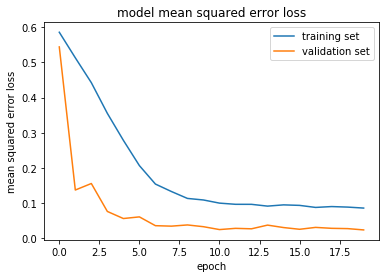

Time:  1
DONE.


In [7]:
model = architecture()

breadth = 21
numTimes = 1
numEpoch = 20

print("samples_per_epoch: ", samples_per_epoch)

val_best = 999

for time in range(numTimes):
    
    trainGenerator = generator(training_datasets, rows_per_dataset, 3)
    validGenerator = generator([validation_dataset], batch_size, 1)
    
    history = model.fit_generator(trainGenerator, 
                                  samples_per_epoch = samples_per_epoch, 
                                  nb_epoch = numEpoch,
                                  validation_data = validGenerator, 
                                  nb_val_samples = nb_val_samples,
                                  verbose = 1)
    
    print(history.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        val_best = val_loss
        
        save_model("model")
        
    print('Time: ', time + 1)
    
print('DONE.')